* **Student**: Miki Seltzer, Minhchau Dang
* **Email Address**: miki.seltzer@berkeley.edu, minhchau.dang@berkeley.edu
* **Course**: 2016-0111 DATASCI W261: Machine Learning at Scale
* **Section**: Spring 2016, Section 2
* **Assignment**: Homework 9, Week 9
* **Submission Date**: March 19, 2016

In [ ]:
%%javascript
require(['base/js/utils'], function(utils) {
    utils.load_extensions('usability/ruler/main');
    utils.load_extensions('usability/toc2/main');
    utils.load_extensions('usability/toggle_all_line_numbers/main');
    utils.load_extensions('autosaveclasses');
});

<IPython.core.display.Javascript object>

# MRJob driver helper utilities

## Notebook imports

If the following cell (which imports all the Python packages used by the different drivers) doesn't run, some of the drivers and helper functions in the notebook will also fail to run. Note that you will also need `mrjob` to run the actual jobs themselves.

In [ ]:
%matplotlib inline

from __future__ import division
from collections import defaultdict
from datetime import datetime
import functools
from IPython.display import display
import json
import math
import matplotlib
import networkx
import numpy
import os
import pandas
import subprocess
import sys

pandas.set_option('display.precision', 4)
pandas.set_option('display.max_rows', 200)

## Hadoop settings

The following settings are used by the Hadoop jobs scattered throughout the notebook and should be updated to reflect the size of your Hadoop cluster.

In [ ]:
hdfs_base_folder = '/user/ubuntu'
mapper_count = 16
reducer_count = 16
debug_output = '/dev/null'

## File management utilities

Different runner types have keep their files in different locations. These utility methods allow us to get some uniformity in the scripts since it will return the actual paths needed by different runner types.

In [ ]:
"""
Returns whether the given file path corresponds to something on the file system used by
the given runner.
"""
def file_exists(runner_type, name):
    if runner_type in ['inline', 'local']:
        return os.path.isfile(name)

    status = subprocess.call([
        'hdfs', 'dfs', '-test', '-f', hdfs_base_folder + '/' + name
    ])

    return status == 0

"""
Returns whether the given file path corresponds to something on the file system used by
the given runner.
"""
def folder_exists(runner_type, name):
    if runner_type in ['inline', 'local']:
        return os.path.isdir(name)

    status = subprocess.call([
        'hdfs', 'dfs', '-test', '-d', hdfs_base_folder + '/' + name
    ])

    return status == 0

"""
Removes the folder located at the given path. Note that it does a recursive remove, so it
doesn't throw an error if it's a file (it will still delete it).
"""
def remove_folder(runner_type, folder_name):
    if runner_type in ['inline', 'local']:
        !rm -rf $folder_name
    else:
        !hdfs dfs -rm -r -f -skipTrash $hdfs_base_folder/$folder_name

"""
Returns an appropriate file path to pass to a runner as an input/output folder.
"""
def get_mrjob_path(runner_type, folder_name):
    if folder_name is None or folder_name == '':
        return ''

    if runner_type in ['inline', 'local']:
        return folder_name

    return 'hdfs://' + hdfs_base_folder + '/' + folder_name

## File download utilities

Since the URLs for the files tend to be very long, first we create some utility methods which make it more clear what we're doing when we're downloading data from either Dropbox or Amazon S3.

In [ ]:
"""
Utility method to split the file to make sure that multiple mapper tasks (and hopefully
multiple reducer tasks) get created for our jobs in Hadoop.
"""
def split_for_hdfs(file_name, target_folder = None):
    if target_folder is None:
        target_folder = file_name

    if folder_exists('hadoop', target_folder):
        return

    !mkdir -p /run/shm/$target_folder
    !split $file_name -l 100000 /run/shm/$target_folder/

    !hdfs dfs -mkdir -p $target_folder
    !hdfs dfs -copyFromLocal /run/shm/$target_folder/* $hdfs_base_folder/$target_folder

    !rm -rf /run/shm/$target_folder

"""
Utility method which downloads a Dropbox file from the folder for this assignment.
"""
def get_dropbox_file(dropbox_folder_name, folder_name, file_name):
    !mkdir -p input/$folder_name
    target_file_path = 'input/%s/%s' % (folder_name, file_name)

    if os.path.isfile(target_file_path):
        return target_file_path

    dropbox_url = 'https://www.dropbox.com/sh'
    !curl -Ls $dropbox_url/$dropbox_folder_name/$file_name > $target_file_path

    return target_file_path

"""
Utility method which downloads a file from an S3 bucket for this assignment.
"""
def get_s3_file(folder_name, file_name):
    !mkdir -p input/$folder_name
    target_file_path = 'input/%s/%s' % (folder_name, file_name)

    if os.path.isfile(target_file_path):
        return target_file_path

    !aws s3 --region us-west-2 cp \
        s3://ucb-mids-mls-networks/$folder_name/$file_name \
        $target_file_path

    return target_file_path

## Content retrieval utilities

We also sometimes need to `grep` a file or `wc -l` the output. The following functions allow us to do so in a runner-agnostic way within the code itself by handling the runner-specific logic here.

In [ ]:
"""
Pipes the standard output for the cat command to the given command and returns the result.
"""
def pipe_cat_output(runner_type, path, command = 'cat'):
    if file_exists(runner_type, path):
        cat_path = path
    elif folder_exists(runner_type, path):
        cat_path = path + '/*'
    else:
        return None

    if runner_type in ['inline', 'local']:
        result = !cat $cat_path | $command
    else:
        result = !hdfs dfs -cat $hdfs_base_folder/$cat_path | $command

    return '\n'.join(result)

"""
Returns the total number of lines in all files contained in the specified folder.
"""
def get_line_count(runner_type, folder_name):
    return int(pipe_cat_output(runner_type, folder_name, 'wc -l'))

"""
Returns the lines in the specified folder starting with the specified key. This can be
parsed by the runner to yield the original key and value.
"""
def get_lines_with_key(runner_type, folder_name, key):
    return pipe_cat_output(runner_type, folder_name, 'grep "^' + key + '"')

# HW 9.0: Short answer questions

## HW 9.0a

> What is PageRank and what is it used for in the context of web search?

PageRank is one of the ranking algorithms used by Google that was introduced by Sergey Brin and Lawrence Page in their paper, [The Anatomy of a Large-Scale Hypertextual Web Search Engine](http://infolab.stanford.edu/~backrub/google.html). At a high level, it provides a measure of "popularity" of pages, due to the underlying assumption that important websites are likely to have more incoming links than unimportant websites.

Because it identifies popular pages, PageRank has several applications in web search.

* PageRank can be used to influence the priority with which web sites are crawled.
* PageRank can be used to provide informed data compression, as popular sites that often come up in search results will require less bits in order to retrieve from disk or transfer over the network.
* PageRank can be used in order to identify an ordering of pages in the inverted index. This allows popular pages arrive first in general search results without additional sorting at query time.

## HW 9.0b

> What modifications have to be made to the webgraph in order to leverage the machinery of Markov Chains to
compute the steady state distribution?

The transformation are described in more detail in the Wikipedia article, [Google matrix](https://en.wikipedia.org/wiki/Google_matrix).

First, we represent the process of visiting pages as a Markov process. To do this, we suggest a random surfer model, wherein a web surfer has some probability of choosing one of the outgoing links on the page. To achieve this, each edge in the webgraph is given a weight that is proportional to the total number of outgoing edges from the source node. We define the weight of the edge as $\large\frac{1}{k}$, where $k$ is the number of outgoing edges for a given node. This results in the sum of the probabilities being 1.

The first problem in the webgraph is dangling nodes (nodes with no outgoing edges), as they will not re-distribute their mass (thus effectively creating a sink). In order to address this problem, we update the webgraph so that from a dangling node, you transition to any other node in the webgraph with uniform probability. This results in these sink nodes being given edges with weight $\large\frac{1}{n}$, where $n$ is the number of nodes in the web graph.

The second problem in the webgraph is the large number of zero probabilities, making it difficult to prove the existence of a steady state distribution. To address this, we introduce
a "teleportation" factor that re-scales the webgraph by a damping factor $d$. We then recapture the $(1 - d)$ mass lost by the scaling and redistribute it to the $n$ nodes of the web graph, thus giving each node $\large\frac{1-d}{n}$ and eliminate all zeroes in the matrix.

Together, this results in a Markov matrix since the entries will be strictly positive ([Perron-Frobenius theorem](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem)).

## HW 9.0c

> OPTIONAL: In topic-specific pagerank, how can we insure that the irreducible property is satified? (HINT: see HW9.4)

In topic-specific PageRank, we can ensure that the irreducible property (strong connectedness) is achieved by scaling the non-uniform teleport factor used by topic-specific PageRank by a factor $\beta \in (0, 1)$ and recapture the $(1 - \beta)$ mass lost in this scaling by redistributing it to the $n - \left|T_j\right|$ nodes with zero values. We can treat this the same way as the teleport factor and do so uniformly.

To retain the topic-specific qualities of topic-specific page rank, $\beta$ must be close to 1 (thus the redistributed mass is very small). Otherwise, we will wind up with anti-topic specific page rank (giving more teleportation weight to pages that are NOT about our topic).

# HW 9.1: MRJob implementation of basic PageRank

This job requires us to do several things:
- Find all nodes in the graph (dangling nodes will not have an explicit neighbors list)
- For each node, maintain graph structure and initialize PageRank to $\large\frac{1}{n}$

## Identify dangling nodes

Some of the PageRank tasks in the homework require that have the dangling nodes included as input when processing the graph, but they are often missing. The following jobs perform a join between the in-degree node table and the out-degree node table to allow us to fix that.

### Create MRJob to tag tables for join

First, we need to tag the different tables so that as we process the input, we know what table we are interacting with.

In [ ]:
from mrjob.job import MRJob
from mrjob.protocol import ReprProtocol
from mrjob.step import MRStep
import sys

class TagWithTableNameJob(MRJob):

    OUTPUT_PROTOCOL = ReprProtocol

    def configure_options(self):
        super(TagWithTableNameJob, self).configure_options()
        self.add_passthrough_option('--mapper-count', default=1)
        self.add_passthrough_option('--table-name')

    """
    Add the table name as part of the value.
    """
    def mapper(self, _, line):
        name, value = line.split('\t', 1)
        yield name, (self.options.table_name, eval(value))

    """
    Set the mapper count options to make sure that MRJob creates enough mapper tasks.
    """
    def steps(self):
        step = MRStep(
            mapper = self.mapper,
            jobconf = {
                'mapreduce.job.maps': self.options.mapper_count
            })

        return [step]

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = TagWithTableNameJob()
    job.run()

Add a utility function to make it easy to call.

In [ ]:
def tag_with_table_name_job(runner_type, graph_file, table_name):
    if graph_file is None:
        return None

    table_file = graph_file + '.table'

    remove_folder(runner_type, table_file)

    mrjob_graph_file = get_mrjob_path(runner_type, graph_file)
    mrjob_table_file = get_mrjob_path(runner_type, table_file)

    !python TagWithTableNameJob.py \
        -r $runner_type \
        --strict-protocols \
        --no-bootstrap-mrjob \
        --no-output \
        --table-name $table_name \
        --output-dir $mrjob_table_file \
        --mapper-count $mapper_count \
        $mrjob_graph_file \
        2>> $debug_output

    return table_file

### Create MRJob to add dangling nodes

Dangling node identification is effectively a full outer join in the sense that we will emit the key as long as it appears in either table, but we only emit the values from the left table (we drop any values from the right table).

In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import ReprProtocol
import sys

class AddDanglingNodesJob(MRJob):

    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol

    def configure_options(self):
        super(AddDanglingNodesJob, self).configure_options()
        self.add_passthrough_option('--left-table')
        self.add_passthrough_option('--right-table')

        self.add_passthrough_option('--mapper-count', type='int', default=1)
        self.add_passthrough_option('--reducer-count', type='int', default=1)

    """
    If you are joining with yourself, that means we didn't have a file which gives you
    degrees for the other table. In this case, we will emit our neighbors in order to
    effectively derive the other table.
    """
    def mapper_init(self):
        self.derive_right_table = self.options.left_table == self.options.right_table

    """
    We are only interested in generating what the left table will be. Therefore, we will
    emit the full entries of the left table, but only an empty value for the right table.
    """
    def mapper(self, name, table_row):
        table_name, neighbors = table_row

        if self.options.left_table == table_name:
            yield name, neighbors
        else:
            yield name, {}

        # If we have to derive the right table, we'll emit each of our neighbors.

        if self.derive_right_table:
            for neighbor_name, degree in neighbors.iteritems():
                yield neighbor_name, {}

    """
    Emit the left table row if found, and emit the blank entry if only right table entries
    were found (dangling node).
    """
    def reducer(self, name, all_neighbors):
        emit_neighbors = {}

        for neighbors in all_neighbors:
            if len(neighbors) != 0:
                emit_neighbors = neighbors

        yield name, emit_neighbors

    """
    Configure the reducer as a combiner and set the mapper and reducer count options to
    make sure that MRJob creates enough mapper/reducer tasks.
    """
    def steps(self):
        step = MRStep(
            mapper_init = self.mapper_init, mapper = self.mapper,
            combiner = self.reducer, reducer = self.reducer,
            jobconf = {
                'mapreduce.job.maps': self.options.mapper_count,
                'mapreduce.job.reduces': self.options.reducer_count
            })

        return [step]

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = AddDanglingNodesJob()
    job.run()

Add a utility function to make it easy to call.

In [ ]:
def add_dangling_nodes_job(runner_type, out_nodes_graph, in_nodes_graph):

    # Tag the tables so that we can perform the join

    if out_nodes_graph is None:
        print 'Failed to create a tagged graph for', out_nodes_graph
        return

    out_nodes_table = tag_with_table_name_job(runner_type, out_nodes_graph, 'out')

    if out_nodes_table is None:
        print 'Failed to create a tagged graph for', out_nodes_graph
        return

    in_nodes_table = tag_with_table_name_job(runner_type, in_nodes_graph, 'in')

    if in_nodes_table is None and in_nodes_graph is not None:
        print 'Failed to create a tagged graph for', in_nodes_graph
        return

    # If we are missing one of the tables, we'll join the table with itself

    left_table = 'out'
    right_table = 'in'

    if in_nodes_graph is None:
        right_table = 'out'
        in_nodes_table = ''

    # Now we run the job with all the tables we've created

    new_nodes_graph = out_nodes_graph + '.all'
    remove_folder(runner_type, new_nodes_graph)

    mrjob_out_nodes_table = get_mrjob_path(runner_type, out_nodes_table)
    mrjob_in_nodes_table = get_mrjob_path(runner_type, in_nodes_table)
    mrjob_new_nodes_graph = get_mrjob_path(runner_type, new_nodes_graph)

    !python AddDanglingNodesJob.py \
        -r $runner_type \
        --strict-protocols \
        --no-bootstrap-mrjob \
        --no-output \
        --left-table $left_table \
        --right-table $right_table \
        --mapper-count $mapper_count \
        --reducer-count $reducer_count \
        --output-dir $mrjob_new_nodes_graph \
        $mrjob_out_nodes_table $mrjob_in_nodes_table \
        2>> $debug_output

    return new_nodes_graph

## Create PageRank MRJob

> Write a basic MRJob implementation of the iterative PageRank algorithm
that takes sparse adjacency lists as input (as explored in HW 7).

> Make sure that you implementation utilizes teleportation (1-damping/the number of nodes in the network),
and further, distributes the mass of dangling nodes with each iteration
so that the output of each iteration is correctly normalized (sums to 1).

> [NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page,
chooses the next page to which it will move by clicking at random, with probability $d$,
one of the hyperlinks in the current page. This probability is represented by a so-called
'damping factor' $d$, where $d \in (0, 1)$. Otherwise, with probability $(1 − d)$, the surfer
jumps to any web page in the network. If a page is a dangling end, meaning it has no
outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform
distribution and "teleports" to that page]

In this job we need to do the following:

- Distribute a node's PageRank to its neighbors
- Distribute the mass of dangling nodes, and account for teleporting

#### Distribute node's PageRank to neighbors

For each node we encounter, we have the current PageRank (let's call this $\text{PR}_{\text{old}}$), and the list of neighbors. We need to divide the PageRank by the number of neighbors, and emit this to each neighbor. If there are no neighbors, we cannot emit the PageRank anywhere, so we accumulate it. Once we accumulate the distributed PageRank mass in each node, we have a preliminary PageRank for each node, which we can denote as $\text{PR}_{\text{int}}$.

#### Distribute the mass of dangling nodes and account for teleporting

We have accumulated the total PageRank mass that has not yet been distributed, because there were no neighbors to distribute the mass to. We also need to account for teleporting. Given the dangling mass, $m$, and the damping factor, $\alpha$, and $n$ nodes, we have the following:

$$
\text{PR}_{\text{new}} = (1-\alpha) \bigg(\frac{1}{n}\bigg) + \alpha\bigg(\frac{m}{n} + \text{PR}_{\text{int}}\bigg)
$$

### Implement PageRank algorithm

First, we want a job that will perform a single iteration of the page rank computation where it will determine the updated page rank based on the rank contribution from all incoming nodes and from random teleport. We also include the known dangling mass from the previous iteration of the algorithm (or, the uniform number of dangling nodes.

In [ ]:
from __future__ import division
import json
from mrjob.job import MRJob
from mrjob.protocol import ReprProtocol
from mrjob.step import MRStep
import sys

class PageRankSingleIterationJob(MRJob):

    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol

    def configure_options(self):
        super(PageRankSingleIterationJob, self).configure_options()

        self.add_passthrough_option('--damping-factor', type='float', default=0.85)

        self.add_passthrough_option('--mapper-count', type='int', default=1)
        self.add_passthrough_option('--reducer-count', type='int', default=1)

    """
    Does nothing here, but can be overridden by sub-classes.
    """
    def load_data(self):
        with open('node_count.txt', 'r') as node_count_file:
            self.node_count = json.load(node_count_file)

        with open('dangling_mass.txt', 'r') as dangling_mass_file:
            self.dangling_mass = json.load(dangling_mass_file)

    """
    Distribute the mass to your neighbors, making sure to emit your own information so
    that is available in the next iteration.
    """
    def mapper(self, key, node_data):

        old_page_rank, neighbors, metadata = self.parse_node_data(key, node_data)

        # Emit yourself with a page rank contribution of zero, but with your neighbors
        # and your old page rank. This allows information to persist between iterations.

        yield str(key), (self.get_empty_mass(), old_page_rank, neighbors, metadata)

        # If you have no neighbors, then you are part of the dangling probability mass.

        neighbor_count = len(neighbors)

        if neighbor_count == 0:
            return

        # Otherwise, redistribute your probability mass to your neighbors.

        distributed_mass = self.get_distributed_mass(key, old_page_rank, neighbor_count)

        for neighbor_name in neighbors.iterkeys():
            yield neighbor_name, (distributed_mass, self.get_empty_mass(), None, None)

    """
    Give all nodes uniform probability in the initial case.
    """
    def parse_node_data(self, key, node_data):
        if isinstance(node_data, dict):
            old_page_rank = 1.0 / self.node_count
            neighbors = node_data
        else:
            old_page_rank = node_data[0]
            neighbors = node_data[2]

        return old_page_rank, neighbors, None

    """
    Distribute mass evenly across all neighbors.
    """
    def get_distributed_mass(self, key, old_page_rank, neighbor_count):
        return old_page_rank / neighbor_count

    """
    Combine the contributions from each node to reduce network usage.
    """
    def combiner(self, key, all_node_data):
        emit_new_rank = self.get_empty_mass()
        emit_old_rank = self.get_empty_mass()
        emit_neighbors = None
        emit_metadata = None

        for new_rank, old_rank, neighbors, metadata in all_node_data:
            emit_new_rank = self.get_merged_mass(emit_new_rank, new_rank)
            emit_old_rank = self.get_merged_mass(emit_old_rank, old_rank)

            if neighbors is not None:
                emit_neighbors = neighbors

            if metadata is not None:
                emit_metadata = metadata

        yield key, (emit_new_rank, emit_old_rank, emit_neighbors, emit_metadata)

    """
    Returns 0
    """
    def get_empty_mass(self):
        return 0.0

    """
    Sum the values together.
    """
    def get_merged_mass(self, old_mass, new_mass):
        return old_mass + new_mass

    """
    Combine the mass from all neighbors. Include mass coming from teleportation, which is
    both from regular nodes (which dedicate part of their mass to teleportation) and from
    dangling nodes (which dedicate all of their mass to teleportation).
    """
    def reducer(self, key, all_node_data):
        emit_new_rank = self.get_empty_mass()
        emit_old_rank = self.get_empty_mass()

        emit_neighbors = {}
        emit_metadata = None

        # Compute the base page rank from incoming nodes.

        for new_rank, old_rank, neighbors, metadata in all_node_data:
            emit_new_rank = self.get_merged_mass(emit_new_rank, new_rank)
            emit_old_rank = self.get_merged_mass(emit_old_rank, old_rank)

            if neighbors is not None:
                emit_neighbors = neighbors

            if metadata is not None:
                emit_metadata = metadata

        # Apply the damping factor to the accumulated mass

        emit_new_rank = self.get_damped_mass(emit_new_rank)

        # Compute the contribution from the dangling mass and the teleport factor.

        if self.options.damping_factor != 1.0:
            dangling_bonus = self.get_dangling_bonus(key, emit_metadata)
            teleport_bonus = self.get_teleport_bonus(key, emit_metadata)

            emit_new_rank = self.get_merged_mass(emit_new_rank, dangling_bonus)
            emit_new_rank = self.get_merged_mass(emit_new_rank, teleport_bonus)

        yield key, (emit_new_rank, emit_old_rank, emit_neighbors, emit_metadata)

    """
    Damped mass is scaled directly since we have a scalar value.
    """
    def get_damped_mass(self, emit_mass):
        return self.options.damping_factor * emit_mass

    """
    Dangling bonus is uniform.
    """
    def get_dangling_bonus(self, key, metadata):
        return self.options.damping_factor * self.dangling_mass / self.node_count

    """
    Teleport bonus is uniform and comes from every node.
    """
    def get_teleport_bonus(self, key, metadata):
        teleport_factor = 1.0 - self.options.damping_factor
        teleport_mass = teleport_factor / self.node_count
        return teleport_mass

    """
    Set the mapper and reducer count options to make sure that MRJob creates enough
    mapper/reducer tasks.
    """
    def steps(self):
        step = MRStep(
            mapper_init = self.load_data, mapper = self.mapper, combiner = self.combiner,
            reducer_init = self.load_data, reducer = self.reducer,
            jobconf = {
                'mapreduce.job.maps': self.options.mapper_count,
                'mapreduce.job.reduces': self.options.reducer_count
            })

        return [step]

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = PageRankSingleIterationJob()
    job.run()

Add a utility function to make it easy to call.

In [ ]:
def page_rank_single_iteration_job(
    python_file, runner_type, graph_file, output_folder, damping_factor):

    mrjob_graph_file = get_mrjob_path(runner_type, graph_file)
    mrjob_output_folder = get_mrjob_path(runner_type, output_folder)

    !python $python_file \
        -r $runner_type \
        --strict-protocols \
        --no-bootstrap-mrjob \
        --no-output \
        --file node_count.txt \
        --file dangling_mass.txt \
        --damping-factor $damping_factor \
        --mapper-count $mapper_count \
        --reducer-count $reducer_count \
        --output-dir $mrjob_output_folder \
        $mrjob_graph_file \
        2>> $debug_output

### Implement post-job computations

Next, we need to compute the probability mass associated with dangling nodes so that we can properly update our page rank computation, factoring in teleportation. Additionally, we want to check for convergence.

In [ ]:
from __future__ import division
import json
from mrjob.job import MRJob
from mrjob.protocol import ReprProtocol
from mrjob.step import MRStep
import sys

class CheckPageRankConvergenceJob(MRJob):

    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol

    def configure_options(self):
        super(CheckPageRankConvergenceJob, self).configure_options()
        self.add_passthrough_option('--mapper-count', type='int', default=1)

    def mapper_init(self):
        with open('node_count.txt', 'r') as node_count_file:
            self.node_count = json.load(node_count_file)

        self.dangling_mass = self.get_empty_mass()
        self.squared_rank_change = self.get_empty_mass()

    """
    Accumulate the probability mass from nodes that have no outgoing links as well as the
    change in rank.
    """
    def mapper(self, key, node_data):
        new_page_rank, old_page_rank, neighbors, metadata = self.parse_node_data(
            key, node_data)

        if len(neighbors) == 0:
            dangling_mass = self.get_dangling_mass(new_page_rank, metadata)

            self.dangling_mass = self.get_merged_mass(
                self.dangling_mass, dangling_mass)

        squared_rank_change = self.get_squared_rank_change(
            new_page_rank, old_page_rank)

        self.squared_rank_change = self.get_merged_mass(
            self.squared_rank_change, squared_rank_change)

    """
    If we just initialized, there's no page rank to speak of. Otherwise, extract the
    metadata from the fields.
    """
    def parse_node_data(self, key, node_data):
        if isinstance(node_data, dict):
            new_page_rank = 1.0 / self.node_count
            old_page_rank = self.get_empty_mass()
            neighbors = node_data
        else:
            new_page_rank = node_data[0]
            old_page_rank = node_data[1]
            neighbors = node_data[2]

        return new_page_rank, old_page_rank, neighbors, None

    """
    Return the mass as-is.
    """
    def get_dangling_mass(self, page_rank, metadata):
        return page_rank

    """
    This is a scalar, so just compute the direct difference.
    """
    def get_squared_rank_change(self, new_page_rank, old_page_rank):
        return (new_page_rank - old_page_rank) ** 2

    """
    Returns 0
    """
    def get_empty_mass(self):
        return 0.0

    """
    Sum the values together.
    """
    def get_merged_mass(self, old_mass, new_mass):
        return old_mass + new_mass

    """
    Yield the accumulated probability mass and squared rank change.
    """
    def mapper_final(self):
        yield 'dangling_mass', self.dangling_mass
        yield 'squared_rank_change', self.squared_rank_change

    """
    Combine the probability mass or the squared rank change.
    """
    def reducer(self, key, values):
        total_value = self.get_empty_mass()

        for value in values:
            total_value = self.get_merged_mass(total_value, value)

        yield key, total_value

    """
    Set the mapper and reducer count options to make sure that MRJob creates enough
    mapper/reducer tasks.
    """
    def steps(self):
        step = MRStep(
            mapper_init = self.mapper_init, mapper = self.mapper,
            mapper_final = self.mapper_final, reducer = self.reducer,
            jobconf = {
                'mapreduce.job.maps': self.options.mapper_count,
                'mapreduce.job.reduces': 2
            })

        return [step]

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = CheckPageRankConvergenceJob()
    job.run()

Add a utility function to make it easy to call.

In [ ]:
def check_page_rank_convergence_job(
    python_file, runner_type, graph_file, load_only = False):

    if graph_file.find('input/') == 0:
        output_folder = 'output/' + graph_file[6:] + '.converge_summary'
    elif graph_file.find('output/') == 0:
        output_folder = graph_file + '.converge_summary'
    else:
        output_folder = 'output/' + graph_file + '.converge_summary'

    if not load_only:
        remove_folder(runner_type, output_folder)

        mrjob_output_folder = get_mrjob_path(runner_type, output_folder)
        mrjob_graph_file = get_mrjob_path(runner_type, graph_file)

        !python $python_file \
            -r $runner_type \
            --strict-protocols \
            --no-bootstrap-mrjob \
            --no-output \
            --file node_count.txt \
            --mapper-count $mapper_count \
            --output-dir $mrjob_output_folder \
            $mrjob_graph_file \
            2>> $debug_output

    # There are two lines in the output, and they summarize the result of the PageRank
    # iteration. Transform them into key-value pairs and return them as a dictionary.

    job_output = pipe_cat_output(runner_type, output_folder)

    convergence_summary = {}

    for line in job_output.strip().split('\n'):
        key, value = line.split('\t', 1)
        convergence_summary[eval(key)] = eval(value)

    return convergence_summary

## Create PageRank driver

Next, provide a driver function which will run a specified number of iterations of the PageRank algorithm, starting from giving all nodes uniform weight, or until the PageRank algorithm converged.

In [ ]:
def page_rank_driver(
    page_rank_python_file, check_converge_python_file, runner_type, graph_file,
    output_base_folder, damping_factor = 0.85, iteration_count = 100,
    converge_threshold = 0.001, show_progress = True, show_final_status = True,
    resume = False):

    # Prepare initial iteration

    iteration_id = 0
    converged = False

    if not resume:
        remove_folder(runner_type, output_base_folder)

    next_graph_file = '%s/%03d' % (output_base_folder, 1)

    while folder_exists(runner_type, next_graph_file):
        iteration_id += 1
        graph_file = next_graph_file
        next_graph_file = '%s/%03d' % (output_base_folder, iteration_id + 1)

    # If we are resuming, check to see if we already converged

    convergence_summary = check_page_rank_convergence_job(
        check_converge_python_file, runner_type, graph_file, iteration_id != 0)

    squared_rank_change = convergence_summary['squared_rank_change']

    if isinstance(squared_rank_change, dict):
        rank_change = max(squared_rank_change.values()) ** 0.5
    else:
        rank_change = squared_rank_change ** 0.5

    dangling_mass = convergence_summary['dangling_mass']

    if iteration_id != 0:
        converged = rank_change <= converge_threshold

    # Iterate until convergence, or until the number of iterations have completed

    while iteration_id < iteration_count and not converged:
        iteration_id += 1

        if show_progress:
            now = datetime.today()
            print now, 'Running PageRank iteration', iteration_id

        next_graph_file = '%s/%03d' % (output_base_folder, iteration_id)

        with open('dangling_mass.txt', 'w') as dangling_mass_file:
            json.dump(dangling_mass, dangling_mass_file)

        page_rank_single_iteration_job(
            page_rank_python_file, runner_type, graph_file, next_graph_file,
            damping_factor)

        if show_progress:
            now = datetime.today()
            print now, 'Running convergence check for iteration', iteration_id

        convergence_summary = check_page_rank_convergence_job(
            check_converge_python_file, runner_type, next_graph_file)

        squared_rank_change = convergence_summary['squared_rank_change']

        if isinstance(squared_rank_change, dict):
            rank_change = max(squared_rank_change.values()) ** 0.5
        else:
            rank_change = squared_rank_change ** 0.5

        converged = rank_change <= converge_threshold

        # Prepare for the next iteration

        dangling_mass = convergence_summary['dangling_mass']
        graph_file = next_graph_file

    if show_final_status:
        now = datetime.today()

        print

        if converged:
            print now, 'PageRank converged after', iteration_id, 'iterations'
        else:
            print now, 'PageRank did not converge after', iteration_id, 'iterations'
            print now, 'PageRank scores moved by', rank_change, 'in last iteration'

    # Return the path to the last graph file so that we can examine it.

    return graph_file

Now we use it for the regular PageRank algorithm.

In [ ]:
run_page_rank = functools.partial(
    page_rank_driver, 'PageRankSingleIterationJob.py', 'CheckPageRankConvergenceJob.py')

## Acquire PageRank test data

> As you build your code, use the test data

> * [s3://ucb-mids-mls-networks/PageRank-test.txt](http://s3-us-west-2.amazonaws.com/ucb-mids-mls-networks/PageRank-test.txt) (S3)
> * https://www.dropbox.com/sh/2c0k5adwz36lkcw/AADxzBgNxNF5Q6-eanjnK64qa/PageRank-test.txt (Dropbox)

> with teleportation parameter $(1-d)$ set to 0.15 (where $d$, the damping factor is set to 0.85).

In [ ]:
test_out = get_dropbox_file(
    '2c0k5adwz36lkcw/AADxzBgNxNF5Q6-eanjnK64qa', 'test', 'PageRank-test.txt')

It's easier to perform the page rank computation if we add all the dangling nodes to the graph.

In [ ]:
test_all = add_dangling_nodes_job('inline', test_out, None)

## Run PageRank on test data

As a convenience for this smaller test graph, provide a method which runs page rank and returns the results as a dictionary.

In [ ]:
def get_page_ranks(
    runner_type, driver, graph_file, output_base_folder, damping_factor = 0.85,
    show_final_status = False, resume = False, iterations = 50):

    result_graph_file = driver(
        runner_type, graph_file, output_base_folder, damping_factor, iterations, 0.0001,
        False, show_final_status, resume)

    output = pipe_cat_output(runner_type, result_graph_file)

    graph = {}

    for line in output.split('\n'):
        key, result = line.split('\t', 1)

        name = eval(key)

        value = eval(result)
        page_rank = value[0]
        neighbors = value[2]

        graph[name] = (page_rank, neighbors)

    return graph

First, we compute the number of dangling nodes.

In [ ]:
test_out_node_count = get_line_count('inline', test_out)
test_all_node_count = get_line_count('inline', test_all)

with open('node_count.txt', 'w') as node_count_file:
    json.dump(test_all_node_count, node_count_file)

In [ ]:
# Since we'll be calling this in the next question, create an alias for it.

get_test_page_ranks = functools.partial(
    get_page_ranks, 'inline', run_page_rank, test_all, 'output/test')

# Run PageRank and time how long it takes to converge on the small test graph.

%time test_page_ranks = get_test_page_ranks(0.85, True)


2016-03-19 07:40:33.256305 PageRank converged after 50 iterations
CPU times: user 547 ms, sys: 398 ms, total: 945 ms
Wall time: 36 s


## Cross-check PageRank test data result

> Crosscheck your work with the true result, displayed in the first image
in the Wikipedia article:

> https://en.wikipedia.org/wiki/PageRank

> Here for reference are the corresponding PageRank probabilities:

> ```
A,0.033
B,0.384
C,0.343
D,0.039
E,0.081
F,0.039
G,0.016
H,0.016
I,0.016
J,0.016
K,0.016
```

In [ ]:
for name, value in sorted(test_page_ranks.items()):
    page_rank, neighbors = value
    print '%s,%0.3f' % (name, page_rank)

A,0.033
B,0.384
C,0.343
D,0.039
E,0.081
F,0.039
G,0.016
H,0.016
I,0.016
J,0.016
K,0.016


# HW 9.2: Exploring PageRank teleportation and network plots

> In order to overcome  problems such as disconnected components, the damping factor (a typical value for $d$ is 0.85) can be varied.
Using the graph in HW9.1, plot the test graph (using networkx, https://networkx.github.io/) for several values of the damping factor,
so that each nodes radius is proportional to its PageRank score.

## Add utility to plot a PageRank graph

In [ ]:
def plot_page_rank(subplot, title, page_ranks):

    # Build up edges and create a graph

    graph = networkx.MultiDiGraph()

    for name, value in page_ranks.iteritems():
        page_rank, neighbors = value
        graph.add_edges_from([
            (name, neighbor_name) for neighbor_name in neighbors.iterkeys()
                if neighbor_name in page_ranks
        ])

    # Compute node sizes and labels based on page rank values. Use square roots of the
    # page rank as the radius scale factor to avoid being misleading about area.

    node_sizes = [
        (page_ranks[node_id][0] ** 0.5) * 10000
            for node_id in graph.nodes()
    ]

    # Create a circular layout for consistency unless we have too many nodes for the
    # circle to make sense.

    if len(node_sizes) <= 20:
        node_labels = {
            node_id: node_id + '\n' + ('%0.01f' % (page_ranks[node_id][0] * 100)) + '%'
                for node_id in graph.nodes()
        }

        node_positions = networkx.circular_layout(graph)
    else:
        node_labels = { node_id: '' for node_id in graph.nodes() }

        node_positions = networkx.fruchterman_reingold_layout(graph)

    # Plot the graph

    networkx.draw_networkx(
        graph,
        ax = subplot,
        style = 'dotted',
        arrows = False,
        node_color = '0.9',
        pos = node_positions,
        node_size = node_sizes,
        labels = node_labels)

    subplot.axis('off')
    subplot.set_title(title)

## Run PageRank with various damping factors

> In particular you should
do this for the following damping factors: [0,0.25,0.5,0.75, 0.85, 1].

First, we'll compute the resulting page rank weights.

In [ ]:
damping_factors = [0.0, 0.25, 0.5, 0.75, 0.85, 1.0]

graphs = {
    damping_factor: get_test_page_ranks(damping_factor)
        for damping_factor in damping_factors
}

## Plot networkx graph for various damping factors

With that, we can plot the graphs.

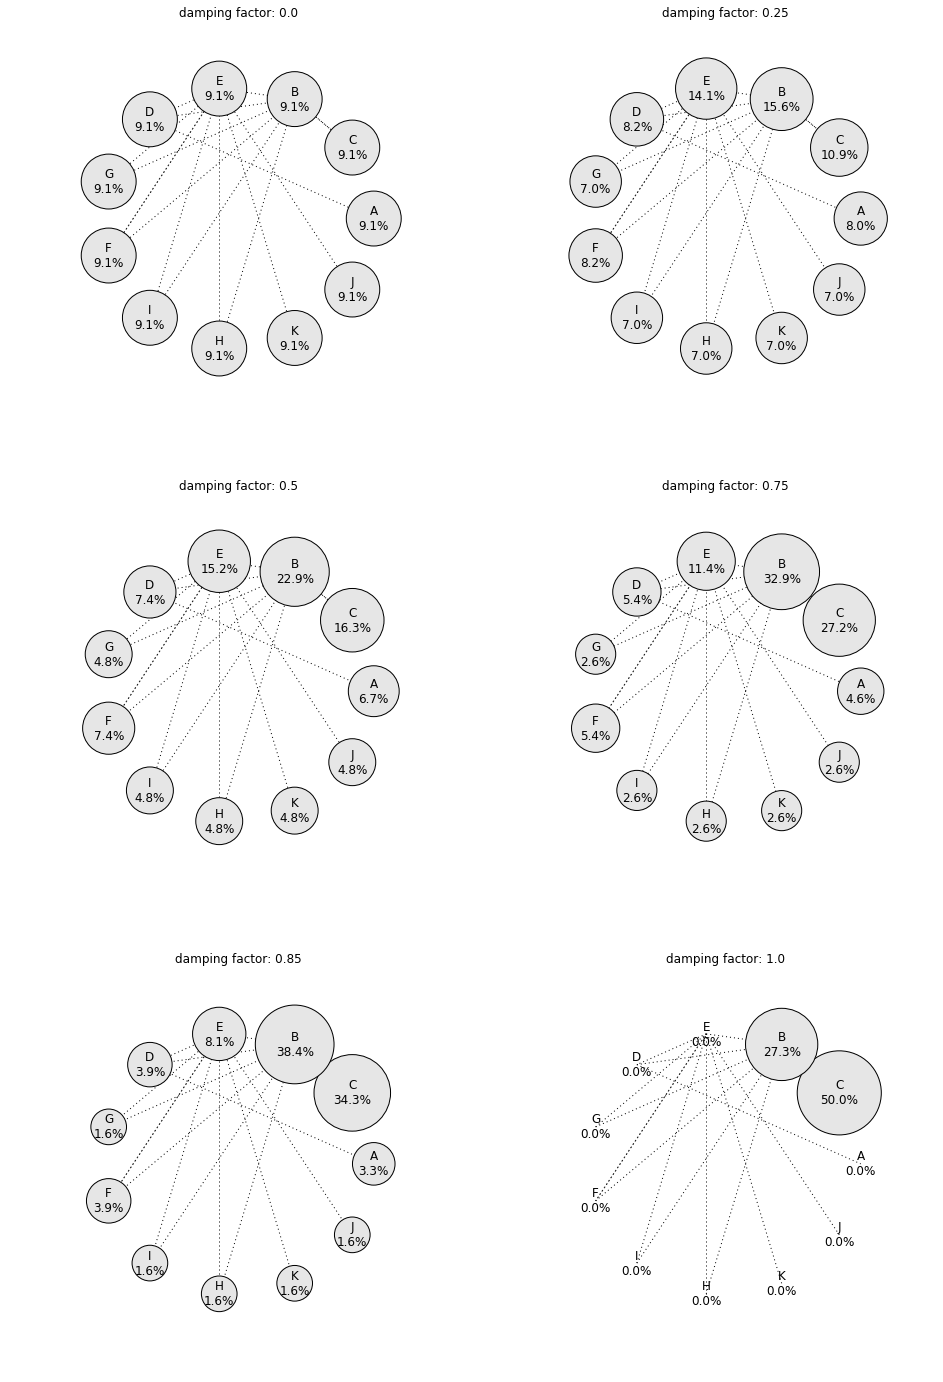

In [ ]:
graph_id = 0

grid_cols = 2
grid_rows = math.ceil(len(damping_factors) / grid_cols)

fig = matplotlib.pyplot.figure(figsize = (16, 8 * grid_rows))

for damping_factor, page_ranks in sorted(graphs.iteritems()):
    graph_id += 1
    subplot = fig.add_subplot(grid_rows, grid_cols, graph_id)
    plot_page_rank(subplot, 'damping factor: ' + str(damping_factor), page_ranks)

# HW 9.3: Applying PageRank to the Wikipedia hyperlinks network

## Acquire Wikipedia hyperlinks network

We will need both the `-out` and the `-in` degree node files.

In [ ]:
wikipedia_out = get_s3_file('wikipedia', 'all-pages-indexed-out.txt')
wikipedia_in = get_s3_file('wikipedia', 'all-pages-indexed-in.txt')
wikipedia_indices = get_s3_file('wikipedia', 'indices.txt')

Split the files so that Hadoop knows to create enough mapper tasks.

In [ ]:
split_for_hdfs(wikipedia_out)
split_for_hdfs(wikipedia_in)
split_for_hdfs(wikipedia_indices)

It's easier to perform the page rank computation if we add all the dangling nodes to the graph.

In [ ]:
%time wikipedia_all = add_dangling_nodes_job('hadoop', wikipedia_out, wikipedia_in)

CPU times: user 8.5 s, sys: 1.13 s, total: 9.62 s
Wall time: 10min 37s


## Create job to sort by PageRank

In [ ]:
import heapq
import math
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import ReprProtocol
import sys

class PageRankTopNJob(MRJob):

    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol

    """
    Allow configuration of the N used for the top-N job.
    """
    def configure_options(self):
        super(PageRankTopNJob, self).configure_options()
        self.add_passthrough_option('--n', default=100, type='int')
        self.add_passthrough_option('--mapper-count', default=1, type='int')

    """
    Initialize our priority queue to an empty list.
    """
    def mapper_init(self):
        self.top_n = []

    """
    Buffer the top N results on the mapper side so that we can emit them during the final
    stage to reduce the amount of network traffic. Allows single reducer approach to work
    for larger networks like the Wikipedia graph.
    """
    def mapper(self, key, node_data):
        old_page_rank, older_page_rank, neighbors = node_data

        # Use log page rank in case we decide to switch over to Hadoop sort rather
        # than an in-memory sort for the reducer.

        log_page_rank = math.log(old_page_rank)
        heap_value = (log_page_rank, key, old_page_rank, older_page_rank, neighbors)

        if len(self.top_n) == self.options.n:
            heapq.heappushpop(self.top_n, heap_value)
        else:
            heapq.heappush(self.top_n, heap_value)

    """
    Emit each of the items to the None key so that we can perform a reducer-side sort.
    """
    def mapper_final(self):
        for item in self.top_n:
            yield None, item

    """
    Reducer which accumulates the top N and then emits them.
    """
    def reducer(self, _, all_items):
        top_n = []

        for item in all_items:
            if len(top_n) == self.options.n:
                heapq.heappushpop(top_n, item)
            else:
                heapq.heappush(top_n, item)

        for item in heapq.nlargest(self.options.n, top_n):
            key = item[1]
            node_data = item[2:]

            yield key, node_data

    """
    Set the mapper and reducer count options to make sure that MRJob creates enough
    mapper/reducer tasks.
    """
    def steps(self):
        step = MRStep(
            mapper_init = self.mapper_init, mapper = self.mapper,
            mapper_final = self.mapper_final, reducer = self.reducer,
            jobconf = {
                'mapreduce.job.maps': self.options.mapper_count,
                'mapreduce.job.reduces': 1
            })

        return [step]

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = PageRankTopNJob()
    job.run()

Add a utility function to make it easy to call.

In [ ]:
def top_n_job(job_file, runner_type, graph_file, n):
    output_folder = graph_file + '.top' + str(n)

    remove_folder(runner_type, output_folder)

    mrjob_graph_file = get_mrjob_path(runner_type, graph_file)
    mrjob_output_folder = get_mrjob_path(runner_type, output_folder)

    !python $job_file \
        -r $runner_type \
        --strict-protocols \
        --no-bootstrap-mrjob \
        --no-output \
        --n $n \
        --mapper-count $mapper_count \
        --output-dir $mrjob_output_folder \
        $mrjob_graph_file \
        2>> $debug_output

    output = pipe_cat_output(runner_type, output_folder)

    topn_graph = {}

    for line in output.split('\n'):
        key, result = line.split('\t', 1)

        name = eval(key)

        value = eval(result)
        page_rank = value[0]
        neighbors = value[2]

        topn_graph[name] = (page_rank, neighbors)

    return topn_graph

In [ ]:
page_rank_top_n_job = functools.partial(top_n_job, 'PageRankTopNJob.py')

Also provide a utility function that can print it in a nice table.

In [ ]:
"""
Prints the nodes in the page rank graph by joining on the given indices file. Essentially
this is a hash join but done outside of MapReduce.
"""
def get_page_rank_table(page_rank_graph):
    node_names = {}

    with open('input/wikipedia/indices.txt') as indices_file:
        for line in indices_file:
            node_name, node_id, rest = line.split('\t', 2)

            if node_id in page_rank_graph:
                node_names[node_id] = node_name

    page_rank_list = [
        (key, node_names[key], value[0])
            for key, value in page_rank_graph.iteritems()
    ]

    sorted_page_rank_list = sorted(page_rank_list, key = lambda x: x[2], reverse = True)

    return pandas.DataFrame(
        sorted_page_rank_list,
        columns = ['NodeId', 'NodeName', 'PageRank'])

## Prepare Wikipedia for PageRank

First, we compute the number of dangling nodes.

In [ ]:
wikipedia_out_node_count = get_line_count('hadoop', wikipedia_out)
wikipedia_all_node_count = get_line_count('hadoop', wikipedia_all)

with open('node_count.txt', 'w') as node_count_file:
    json.dump(wikipedia_all_node_count, node_count_file)

Then, we create a utility function which will run PageRank on the Wikipedia data set using the Hadoop runner.

In [ ]:
run_wikipedia_page_ranks = functools.partial(
    run_page_rank, 'hadoop', wikipedia_all, 'output/wikipedia', 0.85)

## Check PageRank after 5 iterations

> Run your PageRank implementation on the Wikipedia dataset for 5 iterations.

> [s3://ucb-mids-mls-networks/wikipedia/](http://s3-us-west-2.amazonaws.com/ucb-mids-mls-networks/wikipedia/)

> Display the top 100 ranked nodes with $d = 0.85$, corresponding to teleportation factor $(1-d) = 0.15$.

### Run PageRank for 5 iterations

In [ ]:
%time unsorted_wikipedia_page_ranks_05 = \
    run_wikipedia_page_ranks(5, 0, True, False, True)

2016-03-15 06:35:52.298975 Running PageRank iteration 3
2016-03-15 07:00:15.229310 Running convergence check for iteration 3
2016-03-15 07:04:51.012614 Running PageRank iteration 4
2016-03-15 07:27:51.682574 Running convergence check for iteration 4
2016-03-15 07:31:57.421949 Running PageRank iteration 5
2016-03-15 07:55:59.715481 Running convergence check for iteration 5
CPU times: user 1min 10s, sys: 11.8 s, total: 1min 22s
Wall time: 1h 25min 4s


### Check top 100 after 5 iterations

In [ ]:
%time top100_wikipedia_page_ranks_05 = \
    page_rank_top_n_job('hadoop', unsorted_wikipedia_page_ranks_05, 100)

Deleted /user/ubuntu/output/wikipedia/005.top100
CPU times: user 2.35 s, sys: 167 ms, total: 2.52 s
Wall time: 2min 37s


In [ ]:
wikipedia_df_05 = get_page_rank_table(top100_wikipedia_page_ranks_05)
wikipedia_df_05.to_csv('top100_wikipedia_page_ranks_05.csv')
wikipedia_df_05

,NodeId,NodeName,PageRank
0,13455888,United States,0.0015
1,1184351,Animal,0.0007
2,4695850,France,0.0006
3,5051368,Germany,0.0006
4,1384888,Arthropod,0.0005
5,7902219,List of sovereign states,0.0005
6,6113490,Insect,0.0005
7,2437837,Canada,0.0004
8,6076759,India,0.0004
9,13425865,United Kingdom,0.0004


## Check PageRank after 10 iterations

> Run your PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes with $d = 0.85$, corresponding to teleportation factor $(1-d) = 0.15$.

### Run PageRank for 10 iterations

In [ ]:
%time unsorted_wikipedia_page_ranks_10 = \
    run_wikipedia_page_ranks(10, 0, True, False, True)

2016-03-15 08:19:25.593177 Running PageRank iteration 6
2016-03-15 08:37:10.350500 Running convergence check for iteration 6
2016-03-15 08:40:24.715343 Running PageRank iteration 7
2016-03-15 08:57:09.767643 Running convergence check for iteration 7
2016-03-15 09:00:46.333433 Running PageRank iteration 8
2016-03-15 09:18:32.381305 Running convergence check for iteration 8
2016-03-15 09:22:03.980942 Running PageRank iteration 9
2016-03-15 09:39:52.245350 Running convergence check for iteration 9
2016-03-15 09:43:28.774334 Running PageRank iteration 10
2016-03-15 10:00:14.413423 Running convergence check for iteration 10
CPU times: user 1min 28s, sys: 10.9 s, total: 1min 39s
Wall time: 1h 44min 32s


### Check top 100 after 5 iterations

In [ ]:
%time top100_wikipedia_page_ranks_10 = \
    page_rank_top_n_job('hadoop', unsorted_wikipedia_page_ranks_10, 100)

CPU times: user 2.18 s, sys: 395 ms, total: 2.58 s
Wall time: 2min 23s


In [ ]:
wikipedia_df_10 = get_page_rank_table(top100_wikipedia_page_ranks_10)
wikipedia_df_10.to_csv('top100_wikipedia_page_ranks_10.csv')
wikipedia_df_10

,NodeId,NodeName,PageRank
0,13455888,United States,0.0015
1,1184351,Animal,0.0007
2,4695850,France,0.0006
3,5051368,Germany,0.0006
4,1384888,Arthropod,0.0005
5,2437837,Canada,0.0004
6,6113490,Insect,0.0004
7,7902219,List of sovereign states,0.0004
8,13425865,United Kingdom,0.0004
9,6076759,India,0.0004


## Compare top 100 for different iterations

> Have the top 100 ranked pages changed? Comment on your findings.

### Overlap check

Find the set intersection to check for the number of nodes that overlap.

In [ ]:
top100_nodes_05 = set(top100_wikipedia_page_ranks_05.keys())
top100_nodes_10 = set(top100_wikipedia_page_ranks_10.keys())

intersection = top100_nodes_05 & top100_nodes_10
print 'intersection:', len(intersection), 'nodes'

intersection: 98 nodes


From the size of the intersection, we can see that the top 100 are consistently the same pages after the first 10 iterations (there is a 98% overlap) and that any position changes in the top 100 are probably switches between the pages.

### Distance check

We can also check the Levenshtein distance between the two rankings to see how much the rankings themselves have changed.

In [ ]:
# Borrowed under Creative Commons
# http://hetland.org/coding/python/levenshtein.py

def levenshtein(a,b):
    "Calculates the Levenshtein distance between a and b."
    n, m = len(a), len(b)
    if n > m:
        # Make sure n <= m, to use O(min(n,m)) space
        a,b = b,a
        n,m = m,n

    current = range(n+1)
    for i in range(1,m+1):
        previous, current = current, [i]+[0]*n
        for j in range(1,n+1):
            add, delete = previous[j]+1, current[j-1]+1
            change = previous[j-1]
            if a[j-1] != b[i-1]:
                change = change + 1
            current[j] = min(add, delete, change)

    return current[n]

levenshtein(wikipedia_df_05['NodeId'].tolist(), wikipedia_df_10['NodeId'].tolist())

48

The Levenshtein distance is 48, indicating that the similarity between the two rankings is only 52%. Therefore, while there is substantial overlap, the two are not as similar as the overlap suggests. Namely, while the top 100 has been more or less established, between the fifth iterations and the tenth iteration, there have been rank switches.

## Plot PageRank of top 100 ranked pages

> Plot the pagerank values for the top 100 pages resulting from the 5 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.

While we could create a MapReduce job to retrieve the new value of the top 100 pages, we know from the previous analysis of the overlaps that we're actually only missing two values, and checking the merged result tables, they are both very low rank (species at rank 91 and Eudicots at rank 97).

In [ ]:
wikipedia_df_05 = pandas.DataFrame.from_csv('top100_wikipedia_page_ranks_05.csv')
wikipedia_df_10 = pandas.DataFrame.from_csv('top100_wikipedia_page_ranks_10.csv')

wikipedia_compare_df = pandas.merge(
    wikipedia_df_05[['NodeName', 'PageRank']],
    wikipedia_df_10[['NodeName', 'PageRank']],
    on = ['NodeName'], how = 'left')

wikipedia_compare_df.columns = [
    'NodeName', 'PageRank after 5 Iterations', 'PageRank after 10 Iterations'
]

wikipedia_compare_df

,NodeName,PageRank after 5 Iterations,PageRank after 10 Iterations
0,United States,0.0015,0.0015
1,Animal,0.0007,0.0007
2,France,0.0006,0.0006
3,Germany,0.0006,0.0006
4,Arthropod,0.0005,0.0005
5,List of sovereign states,0.0005,0.0004
6,Insect,0.0005,0.0004
7,Canada,0.0004,0.0004
8,India,0.0004,0.0004
9,United Kingdom,0.0004,0.0004


With the values all grouped together in a table, we can compare the plotted raw values for the page ranks.

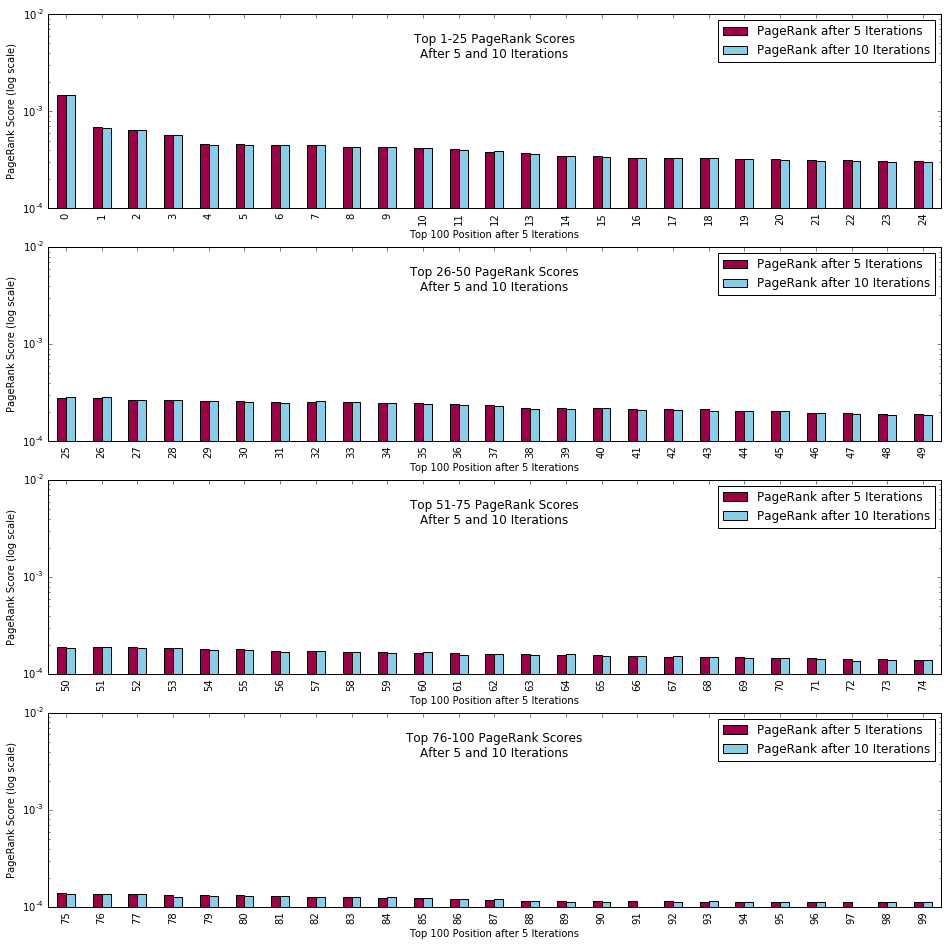

In [ ]:
plot_count = 4

figure, subplots = matplotlib.pyplot.subplots(
    plot_count, figsize = (16, 4 * plot_count), sharex = False, sharey = True)

for i in range(plot_count):
    start = int(i * 100 / plot_count)
    end = int((i + 1) * 100 / plot_count)

    wikipedia_compare_df[start:end].plot(
        ax = subplots[i], logy = True, kind = 'bar', color=['#9C0046', '#87ceeb'])

    subplots[i].title.set_position((0.5,0.75))

    subplots[i].set_title(
        'Top %d-%d PageRank Scores\nAfter 5 and 10 Iterations' % (start + 1, end))

    subplots[i].set_xlabel('Top 100 Position after 5 Iterations')
    subplots[i].set_ylabel('PageRank Score (log scale)')

# HW 9.4: Topic-specific PageRank implementation using MRJob

## Add topics to graph

### Create MRJob to count topic occurrences

Unlike regular PageRank, topic-specific page rank needs separate counts for each topic in order to handle the dangling mass, so we'll create a job for it.

In [ ]:
from collections import defaultdict
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import ReprProtocol
import sys

class TopicOccurrenceCountJob(MRJob):

    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol

    def configure_options(self):
        super(TopicOccurrenceCountJob, self).configure_options()

        self.add_passthrough_option('--mapper-count', type='int', default=1)
        self.add_passthrough_option('--reducer-count', type='int', default=1)

    """
    Initialize all topic counts to zero.
    """
    def mapper_init(self):
        self.topic_counts = defaultdict(int)

    """
    Accumulate the topic counts within a mapper.
    """
    def mapper(self, name, topic):
        self.topic_counts[topic] += 1

    """
    Yield the accumulated topic counts.
    """
    def mapper_final(self):
        for topic, count in self.topic_counts.iteritems():
            yield topic, count

    """
    Sum the accumulated topic counts.
    """
    def reducer(self, topic, counts):
        yield topic, sum(counts)

    """
    Set the mapper and reducer count options to make sure that MRJob creates enough
    mapper/reducer tasks.
    """
    def steps(self):
        step = MRStep(
            mapper_init = self.mapper_init, mapper = self.mapper,
            mapper_final = self.mapper_final, reducer = self.reducer,
            jobconf = {
                'mapreduce.job.maps': self.options.mapper_count,
                'mapreduce.job.reduces': self.options.reducer_count
            })

        return [step]

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = TopicOccurrenceCountJob()
    job.run()

Add a utility function to make it easy to call.

In [ ]:
def topic_occurrence_type_job(runner_type, topic_file):
    if topic_file is None:
        return None

    count_file = topic_file + '.counts'

    remove_folder(runner_type, count_file)

    mrjob_topic_file = get_mrjob_path(runner_type, topic_file)
    mrjob_count_file = get_mrjob_path(runner_type, count_file)

    !python TopicOccurrenceCountJob.py \
        -r $runner_type \
        --strict-protocols \
        --no-bootstrap-mrjob \
        --no-output \
        --output-dir $mrjob_count_file \
        --mapper-count $mapper_count \
        --reducer-count $reducer_count \
        $mrjob_topic_file \
        2>> $debug_output

    # Gather everything into a dictionary

    job_output = pipe_cat_output(runner_type, count_file)

    topic_counts = {}

    for line in job_output.split('\n'):
        topic, count_string = line.split('\t')
        topic_counts[eval(topic)] = int(count_string)

    return topic_counts

### Create MRJob to add node topics to graph

In essence, we are performing a join on the two tables, with one containing the topic identifier and the other containing the neighbors. Therefore, we can create a job which will do that.

In [ ]:
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import ReprProtocol
import sys

class TagNodeWithTopicJob(MRJob):

    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol

    def configure_options(self):
        super(TagNodeWithTopicJob, self).configure_options()

        self.add_passthrough_option('--mapper-count', type='int', default=1)
        self.add_passthrough_option('--reducer-count', type='int', default=1)

    """
    We can identify whether it is the topic table or the graph table based on whether the
    input is a dictionary or a string/numeric value.
    """
    def mapper(self, name, value):
        if isinstance(value, dict):
            yield str(name), (value, None)
        else:
            topic = str(value)
            yield str(name), (None, topic)

    """
    Emit the left table row if found, and emit the blank entry if only right table entries
    were found (dangling node).
    """
    def reducer(self, name, all_data_rows):
        emit_left_data = None
        emit_right_data = None

        for data_row in all_data_rows:
            left_data, right_data = data_row

            if left_data is not None:
                emit_left_data = left_data
            if right_data is not None:
                emit_right_data = right_data

        yield name, (emit_left_data, emit_right_data)

    """
    Configure the reducer as a combiner and set the mapper and reducer count options to
    make sure that MRJob creates enough mapper/reducer tasks.
    """
    def steps(self):
        step = MRStep(
            mapper = self.mapper, combiner = self.reducer, reducer = self.reducer,
            jobconf = {
                'mapreduce.job.maps': self.options.mapper_count,
                'mapreduce.job.reduces': self.options.reducer_count
            })

        return [step]

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = TagNodeWithTopicJob()
    job.run()

Add a utility function to make it easy to call.

In [ ]:
def tag_node_with_topic_job(runner_type, graph_file, topic_file):
    if graph_file is None or topic_file is None:
        return None

    output_folder = graph_file + '.topic_tagged'

    remove_folder(runner_type, output_folder)

    mrjob_graph_file = get_mrjob_path(runner_type, graph_file)
    mrjob_topic_file = get_mrjob_path(runner_type, topic_file)
    mrjob_output_folder = get_mrjob_path(runner_type, output_folder)

    !python TagNodeWithTopicJob.py \
        -r $runner_type \
        --strict-protocols \
        --no-bootstrap-mrjob \
        --no-output \
        --output-dir $mrjob_output_folder \
        --mapper-count $mapper_count \
        --reducer-count $reducer_count \
        $mrjob_graph_file \
        $mrjob_topic_file \
        2>> $debug_output

    return output_folder

### Create MRJob to use character length as topic

Having a job which uses character length as topic allows us to do the Wikipedia example later (if we choose to do it) and also to use our PageRank test data as a sanity check.

In [ ]:
from collections import defaultdict
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import RawValueProtocol, ReprProtocol
import sys

class CharacterLengthAsTopicJob(MRJob):

    INPUT_PROTOCOL = RawValueProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol

    def configure_options(self):
        super(CharacterLengthAsTopicJob, self).configure_options()

        self.add_passthrough_option('--mapper-count', type='int', default=1)

    """
    Accumulate the topic counts within a mapper.
    """
    def mapper(self, _, line):
        split_line = line.split('\t')

        name = split_line[0]
        node_id = split_line[1]

        yield node_id, str(len(name) % 10)

    """
    Set the mapper count options to make sure that MRJob creates enough mapper tasks.
    """
    def steps(self):
        step = MRStep(
            mapper = self.mapper,
            jobconf = {
                'mapreduce.job.maps': self.options.mapper_count
            })

        return [step]

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = CharacterLengthAsTopicJob()
    job.run()

Add a utility function to make it easy to call.

In [ ]:
def character_length_as_topic_job(runner_type, indexes_file):
    output_folder = indexes_file + '.topics'

    remove_folder(runner_type, output_folder)

    mrjob_indexes_file = get_mrjob_path(runner_type, indexes_file)
    mrjob_output_folder = get_mrjob_path(runner_type, output_folder)

    !python CharacterLengthAsTopicJob.py \
        -r $runner_type \
        --strict-protocols \
        --no-bootstrap-mrjob \
        --no-output \
        --output-dir $mrjob_output_folder \
        --mapper-count $mapper_count \
        $mrjob_indexes_file \
        2>> $debug_output

    return output_folder

## Create Topic-specific PageRank MRJob

### Consider Irreducibility

> Modify your PageRank implementation to produce a topic specific PageRank implementation,
as described in:

> http://www-cs-students.stanford.edu/~taherh/papers/topic-sensitive-pagerank.pdf

> Note in this article that there is a special caveat to ensure that the transition matrix is irreducible.
This caveat lies in footnote 3 on page 3:

> >	A minor caveat: to ensure that M is irreducible when p
	contains any 0 entries, nodes not reachable from nonzero
	nodes in p should be removed. In practice this is not problematic.

> and must be adhered to for convergence to be guaranteed.

> One final and important comment here:  please consider the
requirements for irreducibility with topic-specific PageRank.
In particular, the literature ensures irreducibility by requiring that
nodes not reachable from in-topic nodes be removed from the network.

> This is not a small task, especially as it it must be performed
separately for each of the (10) topics.

> So, instead of using this method for irreducibility,
please comment on why the literature's method is difficult to implement,
and what what extra computation it will require.

Our first task is to remove the unreachable nodes from the outgoing links graph.

* Identify all unreachable nodes
* All unreachable nodes must be removed from the available nodes

First we would have to identify the unreachable nodes of the graph. To do this, we must perform a depth-first search of the graph. We start by performing an initial job which marks the topic nodes as the initial members of the queue and iterate. Rather than mark a node as visited, we can discard it from our graph after queueing the nodes on the frontier in order to reduce network overhead of re-transmitting the graph.

After identifying these nodes, we must remove them from our graph's list of available nodes. To do this, we must perform an anti-join of the original graph with our subgraph of unreachable nodes in order to derive a new graph containing only reachable nodes.

Our second task is to remove the unreachable nodes from the incoming links (the list of neighbors). To do this, we must essentially re-create our list of neighbors, but with the unreachable nodes filtered out.

* Derive the incoming links graph from the updated outgoing links graph
* All unreachable nodes must be removed from the incoming links graph
* Derive the outgoing links graph from the updated incoming links graph

First, we join the outgoing nodes graph with itself by following all edges in the outgoing links table and emitting the tuple `(neighbor, self)`. This results in an incoming links table.

After deriving this incoming links table, we must remove the unreachable nodes from the graph's list of available nodes. To do this, we must perform an anti-join of the derived incoming links graph with our subgraph of unreachable nodes in order to derive a new incoming links graph containing only reachable nodes.

Now that we've finally eliminated the unreachable nodes, we must join the updated incoming links graph with itself by following all edges in the incoming links table and emitting the tuple `(neighbor, self)` to then have the final outgoing nodes graph.

Each of these tasks is individually expensive, and all must be performed before we can even begin iterating over the graph in order to compute the topic-specific PageRank. As a result of all of this extra overhead, the literature's method may not be ideal as a homework assignment with time contraints on implementation.

### Implement topic-specific PageRank algorithm

> Then for your code, please use the alternative,
non-uniform damping vector:

> $\large{v_{ji} = \beta (\frac{1}{\left|T_j\right|})}$; if node $i$ lies in topic $T_j$

> $\large{v_{ji} = (1-\beta)(\frac{1}{N - \left|T_j\right|})}$; if node $i$ lies outside of topic $T_j$

> for $\beta \in (0, 1)$ close to 1.

> With this approach, you will not have to delete any nodes.
If $\beta > 0.5$, PageRank is topic-sensitive,
and if $\beta < 0.5$, the PageRank is anti-topic-sensitive.
For any value of beta irreducibility should hold,
so please try $\beta=0.99$, and perhaps some other values locally,
on the smaller networks.

As noted above, in order to avoid the downside of the computation described in the literature, we will instead avoid removal of the out of topic nodes and perform the following adjustment.

$$
\text{weight}_{ij} =
\begin{cases}
\Large{\frac{\beta}{\left|T_j\right|}}
&\mbox{if } i \mbox{ in topic } T_j \\
\Large{\frac{1-\beta}{N-\left|T_j\right|}}
&\mbox{if } i \mbox{ not in topic } T_j \\
\end{cases}
$$

In this case, we set $\beta = 0.99$.

Topic-specific page rank is essentially identical to regular page rank, except that each phase it emits a page rank for each topic. PageRank is currently coded to make it easy to apply these specifying changes by overriding a few methods. These methods are detailed below.

In [ ]:
from __future__ import division
from mrjob.job import MRJob
from mrjob.protocol import ReprProtocol
from mrjob.step import MRStep
from PageRankSingleIterationJob import PageRankSingleIterationJob
import sys

class TopicPageRankSingleIterationJob(PageRankSingleIterationJob):

    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol

    def configure_options(self):
        super(TopicPageRankSingleIterationJob, self).configure_options()
        self.add_passthrough_option('--beta', type='float', default=0.99)

    """
    Also initialize the total node count.
    """
    def load_data(self):
        super(TopicPageRankSingleIterationJob, self).load_data()

        self.total_node_count = sum(self.node_count.values())
        self.node_count['NOBIAS'] = self.total_node_count

    """
    Give all nodes uniform probability in the initial case.
    """
    def parse_node_data(self, key, node_data):
        if len(node_data) < 3:
            initial_page_rank = 1.0 / self.total_node_count

            old_page_rank = {
                'NOBIAS': initial_page_rank
            }

            for topic in self.node_count.iterkeys():
                old_page_rank[topic] = initial_page_rank

            neighbors = node_data[0]
            metadata = node_data[1]
        else:
            old_page_rank = node_data[0]
            neighbors = node_data[2]
            metadata = node_data[3]

        return old_page_rank, neighbors, metadata

    """
    Distribute mass evenly across all neighbors.
    """
    def get_distributed_mass(self, key, old_page_rank, neighbor_count):
        distributed_mass = {
            topic: page_rank / neighbor_count
                for topic, page_rank in old_page_rank.iteritems()
        }

        return distributed_mass

    """
    Return an empty dictionary.
    """
    def get_empty_mass(self):
        return {}

    """
    Sum the dictionaries together.
    """
    def get_merged_mass(self, old_mass, new_mass):
        for key, value in new_mass.iteritems():
            if key in old_mass:
                old_mass[key] += value
            else:
                old_mass[key] = value

        return old_mass

    """
    Damped mass is scaled for each value.
    """
    def get_damped_mass(self, emit_mass):
        return {
            key: self.options.damping_factor * topic_mass
                for key, topic_mass in emit_mass.iteritems()
        }

    """
    You only get the dangling bonus for your topic.
    """
    def get_dangling_bonus(self, key, metadata):
        dangling_bonus = {}

        for topic, count in self.node_count.iteritems():
            dangling_mass = self.options.damping_factor * self.dangling_mass[topic]

            if count == self.total_node_count:
                multiplier = 1 / self.total_node_count
            elif topic == metadata:
                multiplier = self.options.beta / count
            else:
                multiplier = (1 - self.options.beta) / (self.total_node_count - count)

            dangling_bonus[topic] = dangling_mass * multiplier

        return dangling_bonus

    """
    You only get the teleport bonus for your topic.
    """
    def get_teleport_bonus(self, key, metadata):
        teleport_bonus = {}

        for topic, count in self.node_count.iteritems():
            teleport_mass = 1 - self.options.damping_factor

            if count == self.total_node_count:
                multiplier = 1 / self.total_node_count
            elif topic == metadata:
                multiplier = self.options.beta / count
            else:
                multiplier = (1 - self.options.beta) / (self.total_node_count - count)

            teleport_bonus[topic] = teleport_mass * multiplier

        return teleport_bonus

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = TopicPageRankSingleIterationJob()
    job.run()

### Implement post-job computations

Next, we need to compute the probability mass associated with dangling nodes so that we can properly update our page rank computation, factoring in teleportation. Additionally, we want to check for convergence.

Most of this code is the same as the original PageRank convergence check, with the exception that we're working with multiple topic vectors rather than a single topic vector.

In [ ]:
from __future__ import division
from CheckPageRankConvergenceJob import CheckPageRankConvergenceJob
from mrjob.protocol import ReprProtocol
from mrjob.step import MRStep
import sys

class CheckTopicPageRankConvergenceJob(CheckPageRankConvergenceJob):

    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol

    """
    Also save the total node count across all topics.
    """
    def mapper_init(self):
        super(CheckTopicPageRankConvergenceJob, self).mapper_init()

        self.total_node_count = sum(self.node_count.values())
        self.node_count['NOBIAS'] = self.total_node_count

        self.dangling_mass = {}
        self.squared_rank_change = {}

        for topic in self.node_count.iterkeys():
            self.dangling_mass[topic] = 0.0
            self.squared_rank_change[topic] = 0.0

    """
    If we just initialized, there's no page rank to speak of. Otherwise, extract the
    metadata from the fields.
    """
    def parse_node_data(self, key, node_data):
        if len(node_data) < 3:
            initial_page_rank = 1.0 / self.total_node_count

            new_page_rank = {}

            for topic in self.node_count.iterkeys():
                new_page_rank[topic] = initial_page_rank

            return new_page_rank, self.get_empty_mass(), node_data[0], node_data[1]
        else:
            return node_data[0], node_data[1], node_data[2], node_data[3]

    """
    Return an empty dictionary.
    """
    def get_empty_mass(self):
        return {}

    """
    Return the mass as-is.
    """
    def get_dangling_mass(self, page_rank, metadata):
        if metadata not in page_rank:
            return None

        return {
            'NOBIAS': page_rank['NOBIAS'],
            metadata: page_rank[metadata]
        }

    """
    For each topic, compute the squared difference
    """
    def get_squared_rank_change(self, new_page_rank, old_page_rank):
        rank_change = {}

        for topic, new_value in new_page_rank.iteritems():
            if topic in old_page_rank:
                old_value = old_page_rank[topic]
                rank_change[topic] = (new_value - old_value) ** 2
            else:
                rank_change[topic] = new_value ** 2

        for topic, old_value in old_page_rank.iteritems():
            if topic not in new_page_rank:
                rank_change[topic] = old_value ** 2

        return rank_change

    """
    Sum the dictionaries together.
    """
    def get_merged_mass(self, old_mass, new_mass):
        for key, value in new_mass.iteritems():
            if key in old_mass:
                old_mass[key] += value
            else:
                old_mass[key] = value

        return old_mass

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = CheckTopicPageRankConvergenceJob()
    job.run()

## Create Topic-specific PageRank driver

Next, provide a driver function which will run a specified number of iterations of the Topic-specific PageRank algorithm, starting from giving all nodes uniform weight, or until the PageRank algorithm converged. Note that since we're extending base classes, these need to be included during the MRJob setup phase.

In [ ]:
!tar -zcf pagerank-source.tar.gz \
    PageRankSingleIterationJob.py \
    CheckPageRankConvergenceJob.py

pagerank_source = '--setup \'export PYTHONPATH=$PYTHONPATH:pagerank-source.tar.gz#/\''

In [ ]:
run_topic_page_rank = functools.partial(
    page_rank_driver,
    'TopicPageRankSingleIterationJob.py ' + pagerank_source,
    'CheckTopicPageRankConvergenceJob.py ' + pagerank_source)

## Run Topic-specific PageRank on test data

As a sanity check, test the Topic-specific PageRank on the test data. We'll give each of the nodes the character length as a topic and then create use this updated file to perform a join with our existing graph.

In [ ]:
!cat input/test/PageRank-test.txt.all/* | cut -d"'" -f 2 | awk '{print $1 "\t" $1 }' \
    > input/test/indices.txt

test_topics = character_length_as_topic_job('inline', 'input/test/indices.txt')
test_tagged_graph_file = tag_node_with_topic_job('inline', test_all, test_topics)

In [ ]:
test_topic_counts = topic_occurrence_type_job('inline', test_topics)

with open('node_count.txt', 'w') as node_count_file:
    json.dump(test_topic_counts, node_count_file)

In [ ]:
%time test_topic_page_ranks = get_page_ranks( \
    'inline', run_topic_page_rank, test_tagged_graph_file, 'output/topic_test', \
    0.85, True)


2016-03-19 07:56:23.233147 PageRank converged after 50 iterations
CPU times: user 449 ms, sys: 525 ms, total: 975 ms
Wall time: 38.2 s


Now we confirm that the values match up.

In [ ]:
test_topic_names = [str(x) for x in test_topic_counts.keys()] + ['NOBIAS']

pandas.DataFrame(sorted([
    (key, ) + tuple([node_data[0][str(topic_name)] for topic_name in test_topic_names])
        for key, node_data in test_topic_page_ranks.items()
]), columns = ['NodeId'] + test_topic_names)

,NodeId,1,NOBIAS
0,A,0.0328,0.0328
1,B,0.3844,0.3844
2,C,0.3429,0.3429
3,D,0.0391,0.0391
4,E,0.0809,0.0809
5,F,0.0391,0.0391
6,G,0.0162,0.0162
7,H,0.0162,0.0162
8,I,0.0162,0.0162
9,J,0.0162,0.0162


## Acquire random network data

> Run topic specific PageRank on the following randomly generated network of 100 nodes:

> * [s3://ucb-mids-mls-networks/randNet.txt](http://s3-us-west-2.amazonaws.com/ucb-mids-mls-networks/randNet.txt) (S3)
> * https://www.dropbox.com/sh/2c0k5adwz36lkcw/AACEBW8MKuzl2L-tH_FmuG9ba/randNet.txt (Dropbox)

> which are organized into ten topics, as described in the file:

> * [s3://ucb-mids-mls-networks/randNet_topics.txt](http://s3-us-west-2.amazonaws.com/ucb-mids-mls-networks/randNet_topics.txt) (S3)
> * https://www.dropbox.com/sh/2c0k5adwz36lkcw/AACTOoH1Oi03JxjOaW-Cy4N8a/randNet_topics.txt (Dropbox)

In [ ]:
randnet_out = get_dropbox_file(
    '2c0k5adwz36lkcw/AACEBW8MKuzl2L-tH_FmuG9ba', 'randNet', 'randNet.txt')
randnet_topics = get_dropbox_file(
    '2c0k5adwz36lkcw/AACTOoH1Oi03JxjOaW-Cy4N8a', 'randNet', 'randNet_topics.txt')

## Run PageRank on random network data

In [ ]:
randnet_node_count = get_line_count('inline', randnet_out)

with open('node_count.txt', 'w') as node_count_file:
    json.dump(randnet_node_count, node_count_file)

In [ ]:
randnet_page_ranks = get_page_ranks( \
    'inline', run_page_rank, randnet_out, 'output/randNet', 0.85, True, False)


2016-03-19 07:56:30.707418 PageRank converged after 6 iterations


In [ ]:
pandas.DataFrame(sorted([
    (key, value[0]) for key, value in randnet_page_ranks.iteritems()
], key = lambda x: int(x[0])), columns = ['NodeId', 'NOBIAS'])

,NodeId,NOBIAS
0,1,0.0079
1,2,0.0103
2,3,0.0083
3,4,0.0090
4,5,0.0068
5,6,0.0097
6,7,0.0089
7,8,0.0101
8,9,0.0150
9,10,0.0111


## Run Topic-specific PageRank on random network data

> Since there are 10 topics, your result should be 11 PageRank vectors
(one for the vanilla PageRank implementation in 9.1, and one for each topic
with the topic specific implementation).

We can go ahead and run the topic-specific page rank on this data set after tagging the graph.

In [ ]:
randnet_tagged_graph_file = tag_node_with_topic_job(
    'inline', randnet_out, randnet_topics)

In [ ]:
randnet_topic_counts = topic_occurrence_type_job('inline', randnet_topics)

with open('node_count.txt', 'w') as node_count_file:
    json.dump(randnet_topic_counts, node_count_file)

In [ ]:
%time randnet_topic_page_ranks = get_page_ranks( \
    'inline', run_topic_page_rank, randnet_tagged_graph_file, 'output/topic_randnet', \
    0.85, True, False)


2016-03-19 07:56:39.545253 PageRank converged after 7 iterations
CPU times: user 132 ms, sys: 70.5 ms, total: 203 ms
Wall time: 7.84 s


Now we can confirm that we actually have 11 PageRank vectors.

In [ ]:
randnet_topic_names = [str(x) for x in randnet_topic_counts.keys()] + ['NOBIAS']

randnet_data_frame = pandas.DataFrame(sorted([
    (key, ) + tuple([node_data[0][str(topic_name)] for topic_name in randnet_topic_names])
        for key, node_data in randnet_topic_page_ranks.items()
], key = lambda x: int(x[0])), columns = ['NodeId'] + randnet_topic_names)

## Check topic PageRank after convergence

> Print out the top ten ranking nodes
and their topics for each of the 11 versions, and comment on your result.
Assume a teleportation factor of 0.15 in all your analyses.

In [ ]:
for topic_name in randnet_topic_names:
    by_pagerank = randnet_data_frame.sort_values(topic_name, ascending = False)
    display(by_pagerank[:10][['NodeId', topic_name]])

,NodeId,1
31,32,0.0206
76,77,0.0205
51,52,0.0198
91,92,0.0195
9,10,0.0186
26,27,0.0185
84,85,0.0178
97,98,0.0177
45,46,0.0175
73,74,0.0160


,NodeId,2
57,58,0.0308
70,71,0.0297
8,9,0.0293
72,73,0.0289
11,12,0.0269
58,59,0.0258
74,75,0.0248
81,82,0.0229
51,52,0.0163
16,17,0.0152


,NodeId,3
14,15,0.0315
69,70,0.0271
85,86,0.0265
90,91,0.0245
65,66,0.0241
1,2,0.0237
30,31,0.0228
39,40,0.0222
19,20,0.0197
73,74,0.0159


,NodeId,4
62,63,0.0262
82,83,0.0218
64,65,0.0206
77,78,0.0202
40,41,0.0199
83,84,0.0195
78,79,0.0184
37,38,0.0175
14,15,0.0168
71,72,0.0167


,NodeId,5
98,99,0.0290
89,90,0.0283
87,88,0.0272
50,51,0.0268
44,45,0.0256
4,5,0.0239
33,34,0.0239
3,4,0.0234
79,80,0.0228
99,100,0.0167


,NodeId,6
12,13,0.0346
55,56,0.0329
36,37,0.0318
10,11,0.0313
68,69,0.0301
22,23,0.0283
14,15,0.0172
84,85,0.0170
51,52,0.0166
73,74,0.0155


,NodeId,7
84,85,0.0268
24,25,0.0266
27,28,0.0248
52,53,0.0248
34,35,0.0242
96,97,0.0234
46,47,0.0229
54,55,0.0226
29,30,0.0221
49,50,0.0201


,NodeId,8
99,100,0.0329
60,61,0.0279
38,39,0.0272
7,8,0.0272
61,62,0.0253
86,87,0.0253
5,6,0.0235
53,54,0.0229
17,18,0.0206
8,9,0.0154


,NodeId,9
93,94,0.0302
13,14,0.0295
41,42,0.0292
20,21,0.0284
56,57,0.0275
95,96,0.0263
23,24,0.0258
62,63,0.0172
60,61,0.0164
73,74,0.0143


,NodeId,10
73,74,0.0263
16,17,0.0236
48,49,0.0236
94,95,0.0206
6,7,0.0199
42,43,0.0194
67,68,0.0190
47,48,0.0190
0,1,0.0190
2,3,0.0186


,NodeId,NOBIAS
14,15,0.0164
73,74,0.0160
62,63,0.0158
99,100,0.0154
84,85,0.0152
8,9,0.0150
57,58,0.0148
70,71,0.0145
60,61,0.0144
51,52,0.0143


First, extract the top 10 for each topic and put it together as a data frame to see if there are any obvious trends when viewing everything together as a grid.

In [ ]:
randnet_top10 = {}

for topic_name in randnet_topic_names:
    by_pagerank = randnet_data_frame.sort_values(topic_name, ascending = False)
    top10_pages = by_pagerank[:10]['NodeId'].tolist()
    randnet_top10[topic_name] = top10_pages

pandas.DataFrame(randnet_top10)

,1,10,2,3,4,5,6,7,8,9,NOBIAS
0,32,74,58,15,63,99,13,85,100,94,15
1,77,17,71,70,83,90,56,25,61,14,74
2,52,49,9,86,65,88,37,28,39,42,63
3,92,95,73,91,78,51,11,53,8,21,100
4,10,7,12,66,41,45,69,35,62,57,85
5,27,43,59,2,84,5,23,97,87,96,9
6,85,68,75,31,79,34,15,47,6,24,58
7,98,48,82,40,38,4,85,55,54,63,71
8,46,1,52,20,15,80,52,30,18,61,61
9,74,3,17,74,72,100,74,50,9,74,52


There appear to be some pages that appear multiple times (9 stands out as it's one digit long), so it would be good to see if there are others that are not as obvious at a glance which also appear multiple times.

In [ ]:
randnet_popularity = defaultdict(int)

for page in numpy.array(randnet_top10.values()).flatten():
    randnet_popularity[page] += 1

randnet_popularity_df = pandas.DataFrame([
    (page, count) for page, count in randnet_popularity.iteritems()
], columns = ['NodeId', 'Count'])

randnet_multi_top10 = randnet_popularity_df[randnet_popularity_df['Count'] != 1]
randnet_multi_top10.sort_values('Count', ascending = False)

,NodeId,Count
52,74,6
17,85,4
69,15,4
80,52,4
3,61,3
5,63,3
42,9,3
59,100,3
55,71,2
70,58,2


We can see that from this top 10 list, pages 63, 100, 15, 9, and 74 appear more than 5 times across all topics and are in the top 6 in the unbiased PageRank. This suggests that either the algorithm is unable to fully remove the influence of these top 5 pages, or that these pages are authoritative on many topics.

# HW 9.5: Applying topic-specific PageRank to Wikipedia

## Create a job to sort by topic-specific PageRank

In [ ]:
import heapq
import math
from mrjob.job import MRJob
from mrjob.step import MRStep
from mrjob.protocol import ReprProtocol
from PageRankTopNJob import PageRankTopNJob
import sys

class TopicPageRankTopNJob(PageRankTopNJob):

    INPUT_PROTOCOL = ReprProtocol
    INTERNAL_PROTOCOL = ReprProtocol
    OUTPUT_PROTOCOL = ReprProtocol

    """
    Allow configuration of the N used for the top-N job.
    """
    def configure_options(self):
        super(TopicPageRankTopNJob, self).configure_options()
        self.add_passthrough_option('--topic')

    """
    Buffer the top N results on the mapper side so that we can emit them during the final
    stage to reduce the amount of network traffic. Allows single reducer approach to work
    for larger networks like the Wikipedia graph.
    """
    def mapper(self, key, node_data):
        old_page_rank, older_page_rank, neighbors = node_data

        # Use log page rank in case we decide to switch over to Hadoop sort rather
        # than an in-memory sort for the reducer.

        log_page_rank = math.log(old_page_rank[self.options.topic])
        heap_value = (log_page_rank, key, old_page_rank, older_page_rank, neighbors)

        if len(self.top_n) == self.options.n:
            heapq.heappushpop(self.top_n, heap_value)
        else:
            heapq.heappush(self.top_n, heap_value)

if __name__ == '__main__' and sys.argv[0].find('ipykernel') == -1:
    job = TopicPageRankTopNJob()
    job.run()

Add a utility method to make it easy to call.

In [ ]:
topic_page_rank_top_n_job = functools.partial(top_n_job, 'TopicPageRankTopNJob.py')

## Prepare Wikipedia for topic-specific PageRank

> Here you will apply your topic-specific PageRank implementation to Wikipedia,
defining topics (very arbitrarily) for each page by the length (number of characters) of the name of the article mod 10, so that there are 10 topics.

We'll give each of the nodes the character length as a topic and then create use this updated file to perform a join with our existing graph.

In [ ]:
%time wikipedia_topics = character_length_as_topic_job('hadoop', wikipedia_indices)

CPU times: user 1.18 s, sys: 231 ms, total: 1.41 s
Wall time: 1min 30s


In [ ]:
%time wikipedia_tagged_graph_file = tag_node_with_topic_job( \
    'hadoop', wikipedia_all, wikipedia_topics)

CPU times: user 8.06 s, sys: 1.19 s, total: 9.26 s
Wall time: 9min 23s


In [ ]:
%time wikipedia_topic_counts = topic_occurrence_type_job('hadoop', wikipedia_topics)

with open('node_count.txt', 'w') as node_count_file:
    json.dump(wikipedia_topic_counts, node_count_file)

CPU times: user 1.71 s, sys: 230 ms, total: 1.94 s
Wall time: 2min 1s


In [ ]:
run_wikipedia_topic_page_ranks = functools.partial(
    run_topic_page_rank, 'hadoop', wikipedia_tagged_graph_file, 'output/topic_wikipedia',
    0.85)

## Check topic-specific PageRank after 5 iterations

> Once again, print out the top ten ranking nodes
and their topics for each of the 11 versions, and comment on your result.
Assume a teleportation factor of 0.15 in all your analyses.

<span style="color: crimson; font-size: 3em; font-weight: bold">TODO</span>

In [ ]:
%time unsorted_wikipedia_topic_page_ranks_05 = \
    run_wikipedia_topic_page_ranks(5, 0, True, False, True)

## Check topic-specific PageRank after 10 iterations

<span style="color: crimson; font-size: 3em; font-weight: bold">TODO</span>

In [ ]:
%time unsorted_wikipedia_topic_page_ranks_10 = \
    run_wikipedia_topic_page_ranks(10, 0, True, False, True)